In [20]:
from cereeberus import ReebGraph, MapperGraph, Interleave
import cereeberus.data.ex_mappergraphs as ex_mg

import matplotlib.pyplot as plt
import numpy as np

In [21]:
# Using PuLP to solve the ILP (Should I use something else?)
import pulp

# Given two mapper graphs and associated matrices, I am trying to see if the problem can be solved using integer linear programming (ILP).

_Note to self: Fill in the ILP details here._

## Let's create two example mapper graphs.

Text(0.5, 1.0, 'M_1')

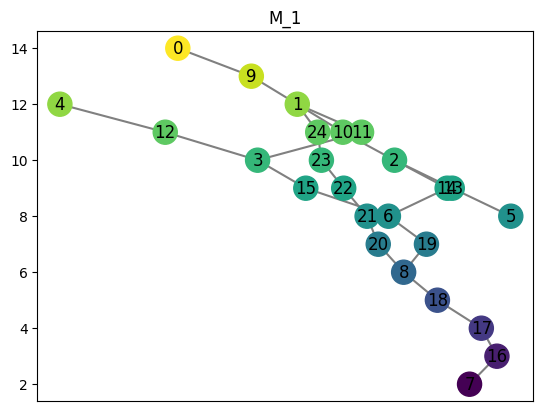

In [22]:
M1 = ex_mg.interleave_example_A()
M1.draw()
plt.title('M_1')

Text(0.5, 1.0, 'M_2')

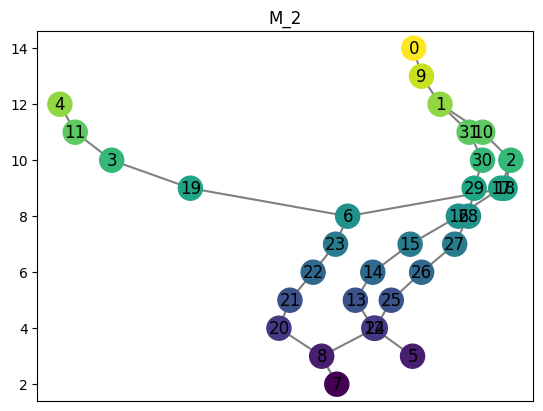

In [23]:
M2 = ex_mg.interleave_example_B()
M2.draw()
plt.title('M_2')

Create an interleaving and to generate all the relevant matrices.

Then, we can try to solve the problem using ILP.

In [24]:
myInt = Interleave(M1, M2, initialize_random_maps=True, seed=10)

## Let's get all the matrices for diagram: Parallelogram with top vertices of the boundary matrices (indexed by 1).

First we need the distance matrix $D^V_{G^n}$.

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]


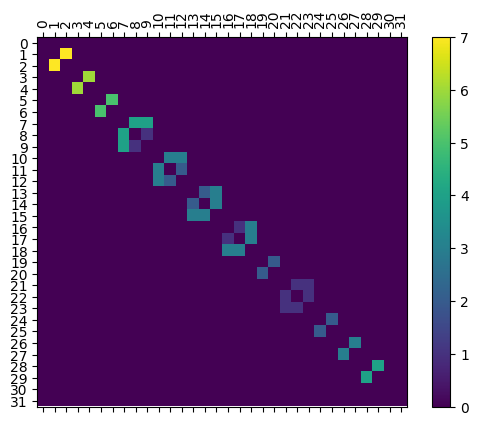

In [25]:
D = myInt.D('G', 'n', 'V')
D.draw(colorbar=True)
D.shape()
print(D.get_all_block_indices())

We need the boundary matrices $B_{F_\text{up}}$ and $B_{G^n_\text{up}}$.

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]


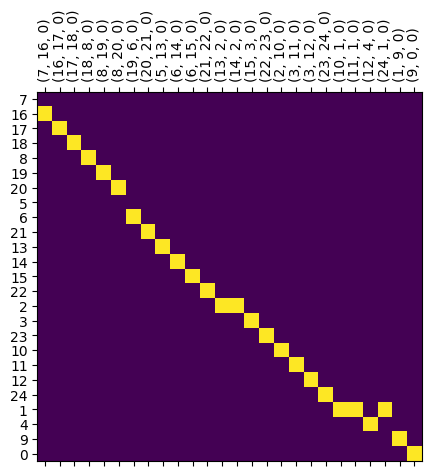

In [26]:
B_F = myInt.B_up('F', '0')
B_F.draw()
B_F.shape()
print(B_F.get_all_block_indices())

(32, 32)

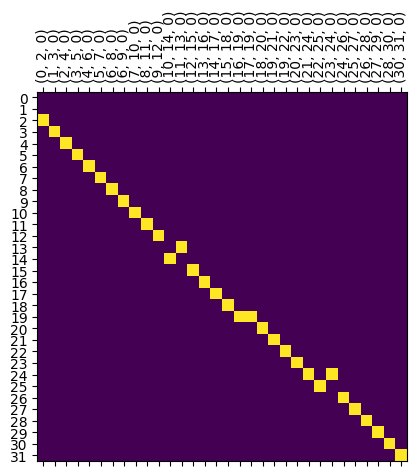

In [27]:
B_G_n = myInt.B_up('G', 'n')
B_G_n.draw()
B_G_n.shape()


We also need the initial phi vertex and edge matrices $\varphi_V$ and $\varphi_E$.

(32, 25)

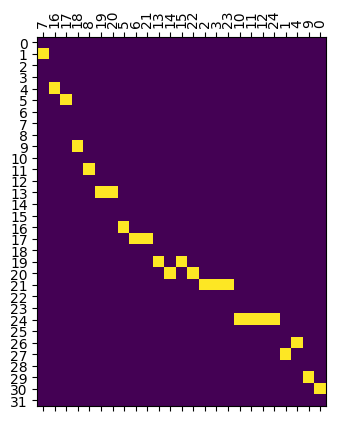

In [28]:
Phi_V = myInt.phi('0','V') 
Phi_V.draw()
Phi_V.shape()

(32, 26)

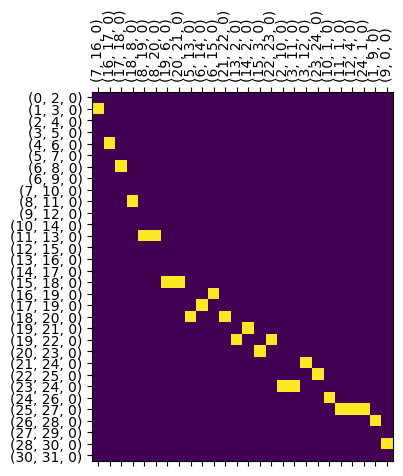

In [29]:
Phi_E = myInt.phi('0','E')
Phi_E.draw()
Phi_E.shape()

# Let's set up the ILP problem.

## Before we set up the variables and constraints, let's set up the dimensions of the matrices. Also save the function values.

In [30]:
# Print the shape of the matrices
print('D.shape:', D.shape())
print('B_F.shape:', B_F.shape())
print('B_G_n.shape:', B_G_n.shape())
print('Phi_V.shape:', Phi_V.shape())
print('Phi_E.shape:', Phi_E.shape())

D.shape: (32, 32)
B_F.shape: (25, 26)
B_G_n.shape: (32, 32)
Phi_V.shape: (32, 25)
Phi_E.shape: (32, 26)


### Initialize the ILP

In [31]:
prob = pulp.LpProblem("ParallelogramILP", pulp.LpMinimize)

### Matrix parameters

In [32]:
# convert everything to numpy arrays
D_mat = D.to_labeled_matrix().get_array()
B_F_mat = B_F.to_labeled_matrix().get_array()
B_G_n_mat = B_G_n.to_labeled_matrix().get_array()
Phi_V_mat = Phi_V.to_labeled_matrix().get_array()
Phi_E_mat = Phi_E.to_labeled_matrix().get_array() 


### Let's set up the dimensions
<span style="color:red"> There has to be a more sophisticated way of choosing the dimensions. </span>

In [33]:
m = D_mat.shape[0] # same as D_mat.shape[1] as D is square also Phi_V_mat.shape[0] and B_G_n_mat.shape[0]
n = Phi_V_mat.shape[1] # same as B_F_mat.shape[0]
o = B_G_n_mat.shape[1] # same as Phi_E_mat.shape[0]
p = B_F_mat.shape[1] # same as Phi_E_mat.shape[1]
print('m:', m, 'n:', n,'o:', o,'p:', p)
print("corresponding letters are (i, h), j, l, k")


m: 32 n: 25 o: 32 p: 26
corresponding letters are (i, h), j, l, k


### Define the decision variables

In [34]:
phi_v_vars = pulp.LpVariable.dicts("phi_v", ((h,j) for h in range(m) for j in range(n)), lowBound=0, cat="Integer")
phi_e_vars = pulp.LpVariable.dicts("phi_e", ((l,k) for l in range(o) for k in range(p)), lowBound=0, cat="Integer")
minmax_var = pulp.LpVariable("m", lowBound=0, upBound=None, cat="Integer")

### Objective function

In [35]:
prob += minmax_var

### Initialize the Assignment Decision Variables



In [36]:
for h in range(m):
    for j in range(n):
        prob += phi_v_vars[h,j] == Phi_V_mat[h][j]

for l in range(o):
    for k in range(p):
        prob += phi_e_vars[l,k] == Phi_E_mat[l][k]

### Constraints
1. $ m \geq \sum_{h=1}^m d^n_{g_{ih}} * (\sum_{j=1}^n \varphi_{v_{hj}} * b_{f_{jk}} - \sum_{l=1}^o b^n_{g_{il}} * \varphi_{e_{lk}})$ for all $i = 1, 2, \ldots, m$ and all  $k = 1, 2, \dots, p$.<br><br>
2. $ -m \leq \sum_{h=1}^m d^n_{g_{ih}} * (\sum_{j=1}^n \varphi_{v_{hj}} * b_{f_{jk}} - \sum_{l=1}^o b^n_{g_{il}} * \varphi_{e_{lk}})$ for all $i = 1, 2, \ldots, m$ and all  $k = 1, 2, \dots, p$.<br><br>

In [37]:
for i in range(m):
    for k in range(p):
        expression = pulp.lpSum([D_mat[i][h] * (pulp.lpSum([phi_v_vars[h,j] * B_F_mat[j][k] for j in range(n)]) - B_G_n_mat[i][l] * phi_e_vars[l,k]) for h in range(m) for l in range(o)])

        prob += minmax_var >= expression
        prob += -minmax_var <= expression

### Constraints

These ones ensure that the $\psi$ and $\phi$ represnent valid assignment. This condition says that the sum of each coulmn should add to 1.

1. $ \sum_{h=1}^{m} \varphi_{V_{hj}} = 1$ for each $j$.
2. $ \sum_{l=1}^{o} \varphi_{E_{lk}} = 1$ for each $k$.

In [38]:
for h in range(m):
    prob += pulp.lpSum(phi_v_vars[h,j] for j in range(n)) == 1   

for l in range(o):
    prob += pulp.lpSum(phi_e_vars[l, k] for k in range(p)) == 1

### Constraints

These constraints ensure that the $\phi_V$ and $\phi_E$ are non-negative.

1. $ \varphi_{V_{hj}} \geq 0$ for each $h$ and $j$.
2. $ \varphi_{E_{lk}} \geq 0$ for each $l$ and $k$.

In [39]:
for h in range(m):
    for j in range(n):
        prob += phi_v_vars[h,j] >= 0

for l in range(o):
    for k in range(p):
        prob += phi_e_vars[l,k] >= 0

### Solve the ILP

In [40]:
prob.solve()

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/ishikaghosh/anaconda3/envs/interleavingenv/lib/python3.13/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/5f/m89pr_zs78n8ffl7t7ndknth0000gn/T/d7b5133e4e614f389f5687dee17396c2-pulp.mps -timeMode elapsed -branch -printingOptions all -solution /var/folders/5f/m89pr_zs78n8ffl7t7ndknth0000gn/T/d7b5133e4e614f389f5687dee17396c2-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 4997 COLUMNS
At line 18673 RHS
At line 23666 BOUNDS
At line 25300 ENDATA
Problem MODEL has 4992 rows, 1633 columns and 10408 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Problem is infeasible - 0.00 seconds
Option for printingOptions changed from normal to all
Total time (CPU seconds):       0.02   (Wallclock seconds):       0.04



-1

## Output the solution

In [41]:
print(f"Objective value (minimization over the maximum of the absolute values of the matrix) = {pulp.value(prob.objective)}")

Objective value (minimization over the maximum of the absolute values of the matrix) = 186.0


Put all the optimized values of the phi and psi matrix back to  matrix form and output it.

In [42]:
final_phi_v = np.zeros((m,n))
final_phi_e = np.zeros((o,p))

for h in range(m):
    for j in range(n):
        final_phi_v[h,j] = pulp.value(phi_v_vars[h,j])

for l in range(o):
    for k in range(p):
        final_phi_e[l,k] = pulp.value(phi_e_vars[l,k])

# are they all zero?
final_phi_e == np.zeros((o,p)), final_phi_v == np.zeros((m,n))

(array([[ True,  True,  True,  True,  True,  True,  True,  True,  True,
          True,  True,  True,  True,  True,  True,  True,  True,  True,
          True,  True,  True,  True,  True,  True,  True,  True],
        [False,  True,  True,  True,  True,  True,  True,  True,  True,
          True,  True,  True,  True,  True,  True,  True,  True,  True,
          True,  True,  True,  True,  True,  True,  True,  True],
        [ True,  True,  True,  True,  True,  True,  True,  True,  True,
          True,  True,  True,  True,  True,  True,  True,  True,  True,
          True,  True,  True,  True,  True,  True,  True,  True],
        [ True,  True,  True,  True,  True,  True,  True,  True,  True,
          True,  True,  True,  True,  True,  True,  True,  True,  True,
          True,  True,  True,  True,  True,  True,  True,  True],
        [ True,  True,  True,  True,  True,  True,  True,  True,  True,
          True,  True,  True,  True,  True,  True,  True,  True,  True,
          True, 

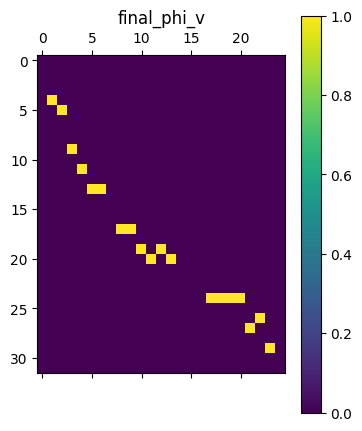

In [43]:
plt.matshow(final_phi_v)
plt.title('final_phi_v')
plt.colorbar()

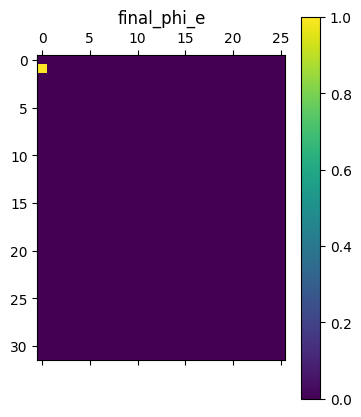

In [44]:
plt.matshow(final_phi_e)
plt.title('final_phi_e')
plt.colorbar()


In [45]:
# check that the column sum adds to one

print("final_phi_v column sum:", np.sum(final_phi_e, axis=0))



final_phi_v column sum: [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]


## Attempt 2: ILP using the parallelogram and triangle functions. Preferably, by block.

In [46]:
from cereeberus import ReebGraph, MapperGraph, Interleave
import cereeberus.data.ex_mappergraphs as ex_mg

import matplotlib.pyplot as plt
import numpy as np

In [47]:
import pulp

### Let's create two example mapper graphs.

Text(0.5, 1.0, 'M_1')

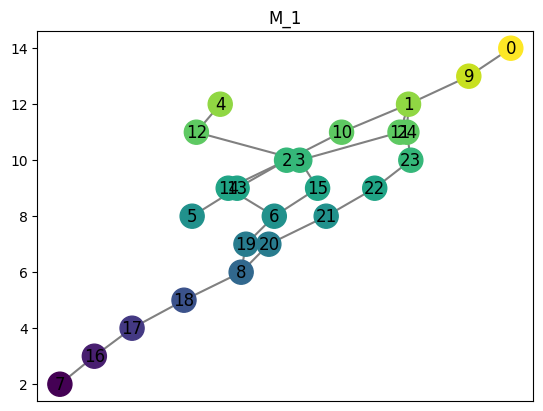

In [48]:
M1 = ex_mg.interleave_example_A()
M1.draw()
plt.title('M_1')

Text(0.5, 1.0, 'M_2')

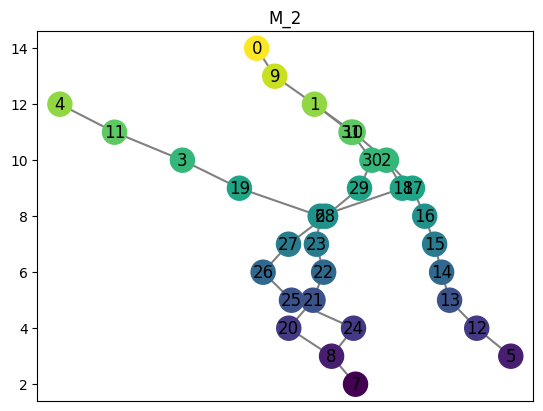

In [49]:
M2 = ex_mg.interleave_example_B()
M2.draw()
plt.title('M_2')

In [50]:
myInt = Interleave(M1, M2, initialize_random_maps=True, seed=190)

In [51]:
for i in range(2,15):
    loss = myInt.loss_each_block(i)
    print(f"loss for block {i} = {loss}")

loss for block 2 = 6.0
loss for block 3 = 5.0
loss for block 4 = 5.0
loss for block 5 = 3.0
loss for block 6 = 2.0
loss for block 7 = 3.0
loss for block 8 = 3.0
loss for block 9 = 2.0
loss for block 10 = 1.0
loss for block 11 = 2.0
loss for block 12 = 3.0
loss for block 13 = 4.0
loss for block 14 = 2.0


### Let's create an ILP for each function value over all the diagrams.

In [52]:
prob = pulp.LpProblem("Minimize_Loss", pulp.LpMinimize)